# ClearML 
It's an end-to-end MLOps management framework with tools to help in every step of the MLOps life-cycle.
This demo showcases (briefly) four of these tools:
- Experiment tracker.
- Data Management.
- Orchestration.
- Hyperparameter optimization.


### Installation:
1) Make a ClearML account (use bitbucket to automatically sync with it).
2) `$ pip install clearml`
3) `$ clearml-init`
    Copy the credentials generated during signup.
4) (optional) Set up your S3/Blob bucket or use the 100gb free ClearML storage tier in the app.

### Experiment Tracker:
A simple MNIST classifier:


At the core of ClearML is the `Task` object. It represents an experiment and will appear in the GUI as such. 

In [1]:
from clearml import Task
task = Task.init(project_name = 'ClearML-demo', task_name = "MNIST classifier", tags=['Notebook'], task_type='training')

ClearML Task: created new task id=567a8604d6b3411eb17d114c346b3898
2022-11-10 17:48:53,553 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/44d201b6aa6d414488f45075bdcb225c/experiments/567a8604d6b3411eb17d114c346b3898/output/log


That's it. We've set up the experiment. Now everything logged into the console (except errors), git differences, Matplotlib images, Argparse arguments, Tensorboard logs will be automatically picked up by the Task.

We can access the experiment ClearML GUI at: 
### app.clear.ml

Let's set up some parameters for our net and connect them to our task.

In [2]:
task_params = {
    'batch_size' : 128,
    'epochs' : 3,
    'hidden_dims' : (512, 256),
    'dropout' : 0.3
}

task.connect(task_params)

{'batch_size': 128, 'epochs': 3, 'hidden_dims': (512, 256), 'dropout': 0.3}

Load and process the data:

In [3]:
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.reshape(60_000, 784)
X_test = X_test.reshape(10_000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

2022-11-10 17:49:02.639740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


60000 train samples
10000 test samples


Some digits: The image will show up under the _debug samples_ tab in the experiment tracker.

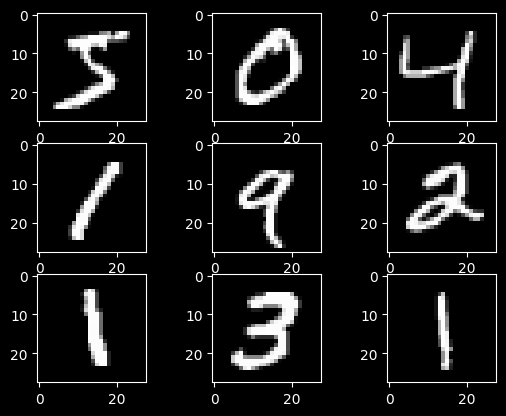

In [4]:
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(3,3,1 + i)
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))

plt.show()

If we want to report a specific plot, scalar, series, image we can use the `Logger` object from ClearML.
Let's report a histogram of a weighted sampling of the numbers 1-5.

In [5]:
import numpy as np
task.logger.report_histogram(title="Histogram", series="first", iteration=0, 
                             values = np.random.choice(np.arange(1,6), 40, p = [0.4, 0.2, 0.2, 0.1, 0.1]))

task.logger.report_histogram(title="Histogram", series="second", iteration=0, 
                             values = np.random.choice(np.arange(1,6), 40, p = [0.2, 0.2, 0.4, 0.1, 0.1]))

Note the iteration keyword arguement. It allows us to log what we need inside training loops.

Back to the model.

In [6]:
import tensorflow_addons as tfa
from keras.layers import Input, Dense, Activation, Dropout

model = keras.Sequential([Input((784,))])

for h_dim in task_params['hidden_dims']:
    model.add(Dense(h_dim))
    model.add(Activation(tfa.activations.mish))
    model.add(Dropout(task_params['dropout']))

model.add(Dense(10))
model.add(Activation('softmax'))



2022-11-10 17:49:06.393467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

Compile and fit the model.
We can write some logs with tensorboard (ClearML will pick them up) and set up a model checkpoint as well.

In [8]:
import os
import tempfile

from keras.callbacks import TensorBoard, ModelCheckpoint

tb_callback = TensorBoard(log_dir = tempfile.gettempdir())
model_store = ModelCheckpoint(filepath=os.path.join(tempfile.gettempdir(), 'weight.{epoch}.hdf5'))

While at it, let's log a confusion matrix after each epoch through a custom callback.

In [9]:
import tensorflow as tf
import seaborn as sns

class ConfMatCallback(keras.callbacks.Callback):
    """Plot a confusion matrix every epoch."""
    def __init__(self, X_test, y_test):
        self.X_test = X_test[:1000]
        self.y_test = y_test[:1000]

    def on_epoch_end(self, epoch, logs=None):
        pred_classes = np.argmax(self.model.predict(self.X_test),axis=1)
        true_classes = np.argmax(self.y_test, axis=1)
        conf_mat = tf.math.confusion_matrix(labels=true_classes, predictions=pred_classes).numpy()
        figure = plt.figure(figsize=(10, 10))
        plt.ioff()
        sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        task.logger.report_matplotlib_figure(title="Confusion Matrix", series = "", iteration=epoch, figure=plt)
        plt.close()
                                    
conf_mat_callback = ConfMatCallback(X_test, y_test)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size = task_params['batch_size'], 
          epochs = task_params['epochs'],
          callbacks = [tb_callback, model_store, conf_mat_callback],
          validation_data = (X_test, y_test)
          )

# Evaluate the model and log the result to ClearML
score = model.evaluate(X_test, y_test)
task.logger.report_single_value("Model final score", value=score[0])
task.logger.report_single_value("Model final score", value=score[1])

2022-11-10 17:49:07.150945: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/3
469/469 [==============================] - 14s 29ms/step - loss: 0.2934 - accuracy: 0.9108 - val_loss: 0.1335 - val_accuracy: 0.9595
Epoch 2/3
469/469 [==============================] - 10s 22ms/step - loss: 0.1308 - accuracy: 0.9592 - val_loss: 0.0896 - val_accuracy: 0.9716
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0737 - accuracy: 0.9770


Close the task to signal the experiment tracker to stop tracking events.

In [11]:
task.close()

Great!  This is not all though.  Let's try something different..

Let's download our data and upload it to the ClearML server.

In [12]:
os.makedirs(os.path.join(tempfile.gettempdir(), 'Data'), exist_ok=True)
np.save(os.path.join(tempfile.gettempdir(), 'Data', 'X_train'), X_train)
np.save(os.path.join(tempfile.gettempdir(), 'Data', 'y_train'), y_train)

np.save(os.path.join(tempfile.gettempdir(), 'Data', 'X_test'), X_test)
np.save(os.path.join(tempfile.gettempdir(), 'Data', 'y_test'), y_test)

In [13]:
data_path = os.path.join(tempfile.gettempdir(), 'Data')
os.listdir(data_path)

['y_test.npy', 'X_test.npy', 'y_train.npy', 'X_train.npy']

We can create a ClearML `Dataset` which is just another type of `Task` and upload the data there as a folder or an artifact.

In [14]:
from clearml import Dataset

dataset = Dataset.create(
    dataset_project = "ClearML-demo",
    dataset_name = "MNIST",
    dataset_tags = ['demo']
)

dataset.add_files(path=data_path)

ClearML results page: https://app.clear.ml/projects/10dc7ee3feef4faa960f624a7609be3c/experiments/b0964808dc25444890e89399eb1fb9f7/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/10dc7ee3feef4faa960f624a7609be3c/experiments/b0964808dc25444890e89399eb1fb9f7
Generating SHA2 hash for 4 files
Hash generation completed


4

We've added the files but it hasn't done anything yet.

Let's upload the and finalize the dataset so no further modifications can be made on this particular data. It allows ClearML to version the data.

In [15]:
dataset.upload()
dataset.finalize()

Uploading dataset changes (4 files compressed to 47.58 MiB) to https://files.clear.ml
File compression and upload completed: total size 47.58 MiB, 1 chunk(s) stored (average size 47.58 MiB)
2022-11-10 17:51:02,741 - clearml.Task - INFO - Waiting to finish uploads
2022-11-10 17:51:03,474 - clearml.Task - INFO - Finished uploading


True

We cann see our data in the server app. We can download it from there if we wish as well.

But why are we doing this? ... 

Let's take a look at `clearml_demo.py`
